# Cancer Diagnosis Model: Predict Breast Cancer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline

from sklearn import ensemble
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Data Set Information:

This dataset was collected by Dr. WIlliam H. Wolberg (physician) and University of Wisconsin Hospitals. The Samples arrived periodically as Dr. Wolberg reports his clinical cases. The database therefore reflects this chronological grouping of the data. This grouping information appears immediately below, having been removed from the data itself: 

    Group 1: 367 instances (January 1989) 
    Group 2: 70 instances (October 1989) 
    Group 3: 31 instances (February 1990) 
    Group 4: 17 instances (April 1990) 
    Group 5: 48 instances (August 1990) 
    Group 6: 49 instances (Updated January 1991) 
    Group 7: 31 instances (June 1991) 
    Group 8: 86 instances (November 1991) 
----------------------------------------- 
Total: 699 points (as of the donated datbase on 15 July 1992) 

## Data Source

Link: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29

## Research Questions and Data Variables

My goal is to create a model that can reliably predict breast cancer. Additionally, I will try to create an explanatory model to find out which variables are most indicative of whether or not an individual will be diagnosed. Overall, this will be a classification model. 

Dataset variables: 
   -- -----------------------------------------
        1. Sample code number            id number
        2. Clump Thickness               1 - 10
        3. Uniformity of Cell Size       1 - 10
        4. Uniformity of Cell Shape      1 - 10
        5. Marginal Adhesion             1 - 10
        6. Single Epithelial Cell Size   1 - 10
        7. Bare Nuclei                   1 - 10
        8. Bland Chromatin               1 - 10
        9. Normal Nucleoli               1 - 10
        10. Mitoses                      1 - 10
        11. Class:                       (2 for benign, 4 for malignant)

In [2]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data", header=None)
data.columns = ['ID', 'clump_thickness', 'uniform_cell_size', 'uniform_cell_shape', 'marginal_adhesion', 
                'single_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses', 'benign_malignant']

## Exploring and Cleaning the Dataset

In [3]:
print(data.shape)
data.head()

(699, 11)


,ID,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,benign_malignant
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


When I begin inspecting my dataset, I first note that bare_nuclei is the only non-integer feature. 

In [4]:
data.dtypes

ID                     int64
clump_thickness        int64
uniform_cell_size      int64
uniform_cell_shape     int64
marginal_adhesion      int64
single_cell_size       int64
bare_nuclei           object
bland_chromatin        int64
normal_nucleoli        int64
mitoses                int64
benign_malignant       int64
dtype: object

I then check to see if there are any null values.

In [5]:
#Before I go any further I want to check in there are any null values in my dataset
print(data.isnull().sum())

ID                    0
clump_thickness       0
uniform_cell_size     0
uniform_cell_shape    0
marginal_adhesion     0
single_cell_size      0
bare_nuclei           0
bland_chromatin       0
normal_nucleoli       0
mitoses               0
benign_malignant      0
dtype: int64


But then I find "?" values in the bare_nuclei feature. I learn from the dataset details that there are 16 instances in Groups 1 to 6 that contain a single missing (i.e., unavailable) attribute value, now denoted by "?" for bare_nuclei. 

In [6]:
data[data.bare_nuclei == '?']

,ID,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,benign_malignant
23,1057013,8,4,5,1,2,?,7,3,1,4
40,1096800,6,6,6,9,6,?,7,8,1,2
139,1183246,1,1,1,1,1,?,2,1,1,2
145,1184840,1,1,3,1,2,?,2,1,1,2
158,1193683,1,1,2,1,3,?,1,1,1,2
164,1197510,5,1,1,1,2,?,3,1,1,2
235,1241232,3,1,4,1,2,?,3,1,1,2
249,169356,3,1,1,1,2,?,3,1,1,2
275,432809,3,1,3,1,2,?,2,1,1,2
292,563649,8,8,8,1,2,?,6,10,1,4


Since my dataset is rather small I decided against removing these data points. I also did not want to assign these values to a 1-10 value because I did not know what effect that would have on my model's predictions. Therefore, I decided to assign a "0" value to these missing values because there are few of them and I did not believe that change would dramatically affect the mode. 

In [7]:
data.bare_nuclei = data.bare_nuclei.replace('?', 0)

In [8]:
# I am changing the bare_nuclei feature from an object to a float data type
data.bare_nuclei = data.bare_nuclei.astype(float)

In [9]:
# Now that my dataset is clean I am going to look at the dataset distribution
data.describe()

,ID,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,benign_malignant
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.463519,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.640708,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [10]:
# Inspecting the percentage of benign and malignant data in this dataset
for each in np.unique(data.benign_malignant):
    print(each)
    print("{}%".format(round((len(data[data.benign_malignant==each])/len(data))*100)))

2
66%
4
34%


In [11]:
#Next I isolate only the continuous variables so that I can visualize any correlation. 
continuous = data.iloc[:, 1:]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


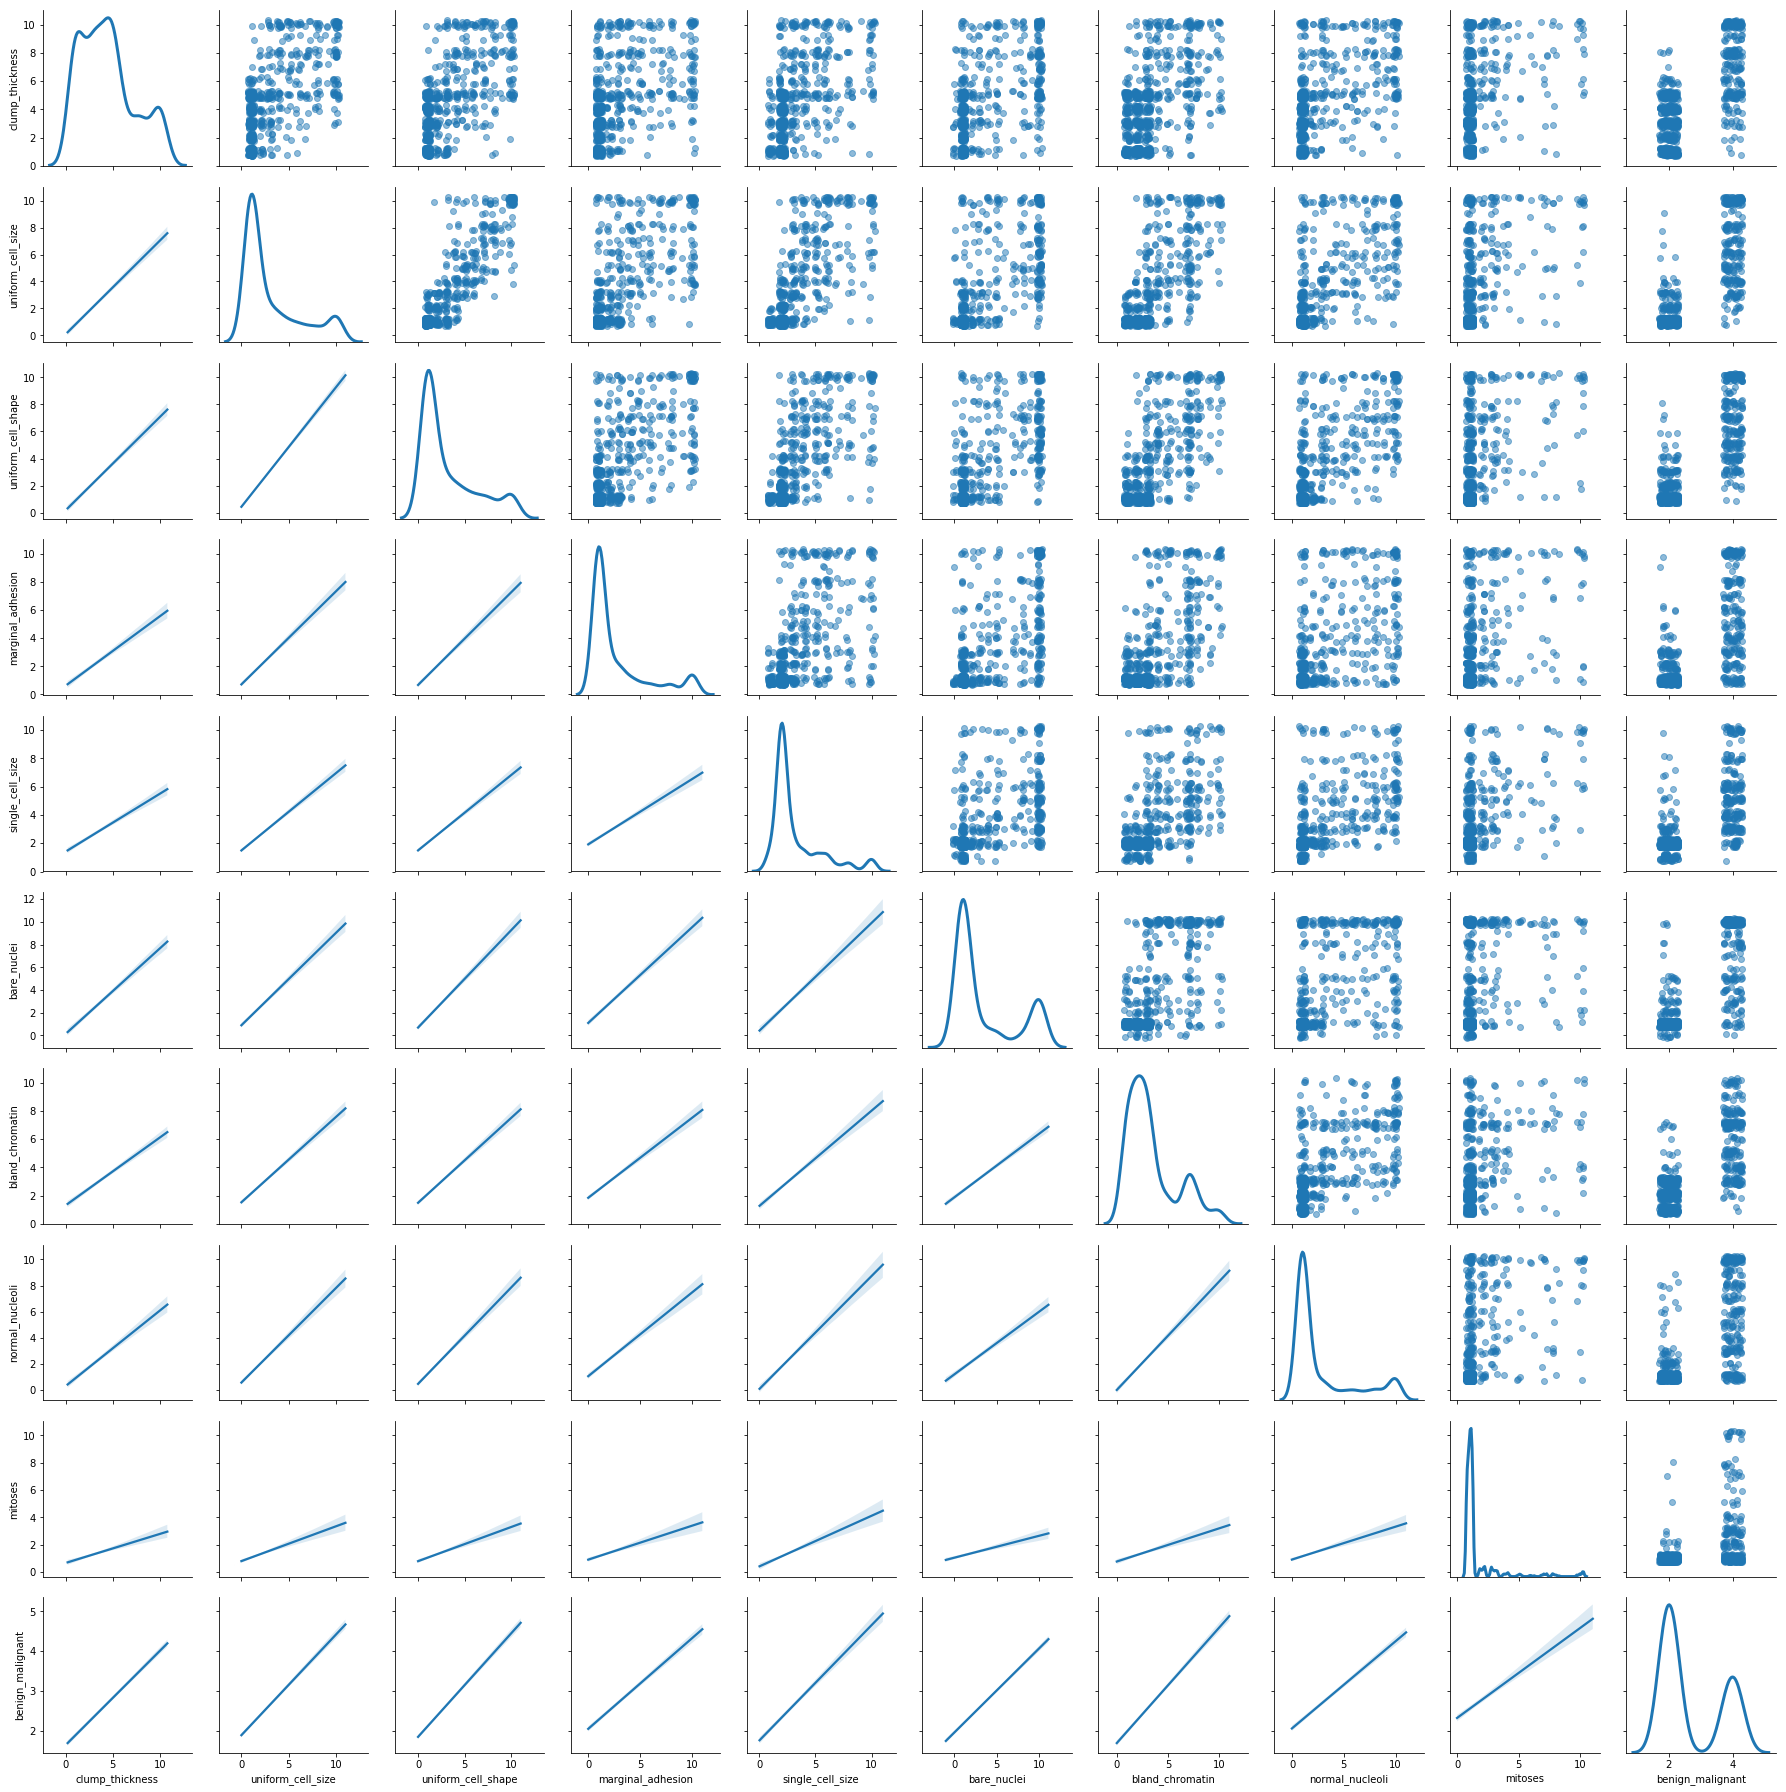

In [12]:
# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(continuous.shape)),
    columns=continuous.columns
)
# Combine the data and the noise.
continuous = continuous.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(continuous.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

In [13]:
# Looking at the correlation of the features
continuous.corr()

,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,benign_malignant
clump_thickness,1.000000,0.643114,0.653195,0.484537,0.519731,0.585298,0.553197,0.533227,0.346360,0.695411
uniform_cell_size,0.643114,1.000000,0.902780,0.700899,0.748749,0.682397,0.750886,0.720614,0.448210,0.801295
uniform_cell_shape,0.653195,0.902780,1.000000,0.681364,0.712426,0.701995,0.729297,0.717302,0.429339,0.805026
marginal_adhesion,0.484537,0.700899,0.681364,1.000000,0.593358,0.663306,0.660379,0.598941,0.410062,0.677505
single_cell_size,0.519731,0.748749,0.712426,0.593358,1.000000,0.579855,0.610355,0.626885,0.474478,0.668650
bare_nuclei,0.585298,0.682397,0.701995,0.663306,0.579855,1.000000,0.668059,0.570235,0.336691,0.799326
bland_chromatin,0.553197,0.750886,0.729297,0.660379,0.610355,0.668059,1.000000,0.662796,0.342426,0.737051
normal_nucleoli,0.533227,0.720614,0.717302,0.598941,0.626885,0.570235,0.662796,1.000000,0.424525,0.695690
mitoses,0.346360,0.448210,0.429339,0.410062,0.474478,0.336691,0.342426,0.424525,1.000000,0.405914
benign_malignant,0.695411,0.801295,0.805026,0.677505,0.668650,0.799326,0.737051,0.695690,0.405914,1.000000


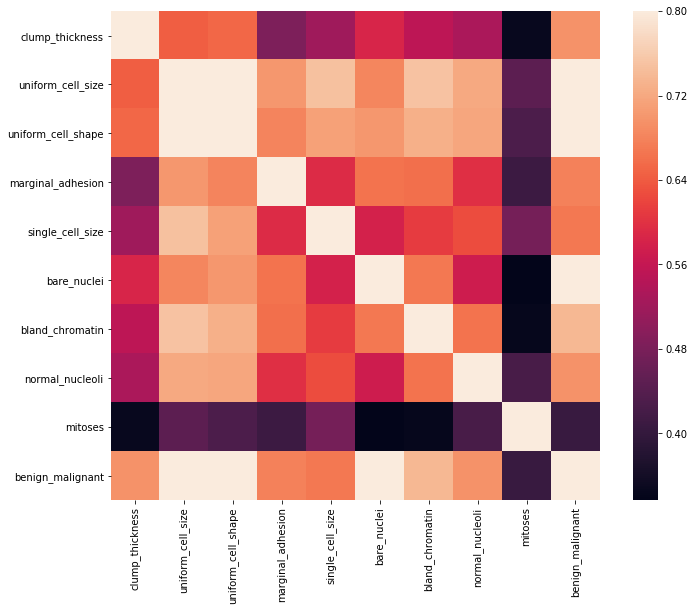

In [14]:
# Make the correlation matrix.
corrmat = continuous.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

## Modeling

Here I am going to separate my data into training and testing dataset. I will also assign my dependent outcome feature and remove it from the remaining independent features.

In [15]:
# Separating my data into train and test datasets
train, test = train_test_split(data, test_size=0.2)

In [16]:
# Setting outcome of interest for both the train and test dataset
train_Y = train.benign_malignant
test_Y = test.benign_malignant

In [17]:
#Drop ID and the outcomes of interest from features
train_data = train.drop(['ID', 'benign_malignant'], axis=1)
test_data = test.drop(['ID', 'benign_malignant'], axis=1)

### Random Forest Classifier

I am beginning my classification models with a random forest classifier because it is very flexible and can provide decent explanation about feature importance.

In [18]:
# Random Forest Classifier
rfc = ensemble.RandomForestClassifier()
rfc.fit(train_data,train_Y)
print(rfc)
print('Training set score:', rfc.score(train_data,train_Y))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Training set score: 0.998211091234347


In [19]:
y_true, y_pred = test_Y, rfc.predict(test_data)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

             precision    recall  f1-score   support

          2       0.99      0.96      0.97        89
          4       0.93      0.98      0.95        51

avg / total       0.97      0.96      0.96       140



array([[85,  4],
       [ 1, 50]])

In [20]:
RFC_score = cross_val_score(rfc, test_data, test_Y, cv=5)
print('\nEach Cross Validated Accuracy: \n', RFC_score)
print("\nOverall Random Forest Classifier Accuracy: %0.2f (+/- %0.2f)\n" % (RFC_score.mean(), RFC_score.std() * 2))


Each Cross Validated Accuracy: 
 [0.96551724 0.96428571 0.92857143 0.82142857 0.92592593]

Overall Random Forest Classifier Accuracy: 0.92 (+/- 0.11)



In [21]:
# Saving the feature names
feature_list = list(test_data.columns)
# Get numerical feature importances
importances = list(rfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [22]:
feature_importances = feature_importances[:20]
feature_importances

[('uniform_cell_size', 0.19),
 ('bland_chromatin', 0.19),
 ('single_cell_size', 0.16),
 ('uniform_cell_shape', 0.15),
 ('bare_nuclei', 0.12),
 ('normal_nucleoli', 0.09),
 ('clump_thickness', 0.07),
 ('marginal_adhesion', 0.02),
 ('mitoses', 0.01)]

### Gradient Boosting Classifier

Next, I decided to move onto a gradient boosting classifier model. This is because it often can have a stronger and more reliable performance than random forest models while still providing some explanatory insight in the features.

In [23]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier()
clf.fit(train_data,train_Y)
print(clf)
print('Training set score:', clf.score(train_data,train_Y))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Training set score: 1.0


In [24]:
y_true, y_pred = test_Y, clf.predict(test_data)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

             precision    recall  f1-score   support

          2       0.98      0.94      0.96        89
          4       0.91      0.96      0.93        51

avg / total       0.95      0.95      0.95       140



array([[84,  5],
       [ 2, 49]])

In [25]:
CLF_score = cross_val_score(clf, test_data, test_Y, cv=5)
print('\nEach Cross Validated Accuracy: \n', CLF_score)
print("\nOverall Gradient Boosted Classifier Accuracy: %0.2f (+/- %0.2f)\n" % (CLF_score.mean(), CLF_score.std() * 2))


Each Cross Validated Accuracy: 
 [0.96551724 0.96428571 0.85714286 0.85714286 0.92592593]

Overall Gradient Boosted Classifier Accuracy: 0.91 (+/- 0.10)



In [26]:
# Saving the feature names
feature_list = list(test_data.columns)
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [27]:
feature_importances = feature_importances[:20]
feature_importances

[('uniform_cell_size', 0.19),
 ('bare_nuclei', 0.19),
 ('clump_thickness', 0.13),
 ('normal_nucleoli', 0.13),
 ('single_cell_size', 0.12),
 ('uniform_cell_shape', 0.1),
 ('marginal_adhesion', 0.08),
 ('mitoses', 0.03),
 ('bland_chromatin', 0.02)]

### Logistic Regression

Lastly, I moved onto a logistic regression model because it is a very strong model that has many of the benefits of a linear regression model while being applicable to a binary dependent variable. Specifically, a logistic model is one where the log-odds of the probability of an event is a linear combination of independent variables. As a result, the logistic regression model allows for the best feature explanation so far because I can find out the coefficients of each of my dataset's features. 

In [28]:
lr = LogisticRegression()
lr.fit(train_data,train_Y)
print(lr)
print('Training set score:', lr.score(train_data,train_Y))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Training set score: 0.9677996422182469


In [29]:
y_true, y_pred = test_Y, lr.predict(test_data)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

             precision    recall  f1-score   support

          2       0.99      0.96      0.97        89
          4       0.93      0.98      0.95        51

avg / total       0.97      0.96      0.96       140



array([[85,  4],
       [ 1, 50]])

In [31]:
LR_score = cross_val_score(lr, test_data, test_Y, cv=5)
print('\nEach Cross Validated Accuracy: \n', LR_score)
print("\nOverall Logistic Regression Accuracy: %0.2f (+/- %0.2f)\n" % (LR_score.mean(), LR_score.std() * 2))


Each Cross Validated Accuracy: 
 [0.96551724 0.96428571 0.96428571 0.85714286 0.96296296]

Overall Logistic Regression Accuracy: 0.94 (+/- 0.09)



In [32]:
print('Coefficients')
print(lr.coef_)
print(lr.intercept_)

Coefficients
[[ 0.2573296   0.25984679  0.28562993  0.17302691 -0.15474573  0.39824604
   0.0349105   0.20726868  0.16916284]]
[-5.84639753]


In [36]:
coefficients = pd.concat([pd.DataFrame(test_data.columns),pd.DataFrame(np.transpose(lr.coef_))], axis = 1)

In [38]:
coefficients.columns = ['features', 'coefficients']

In [39]:
coefficients

,features,coefficients
0,clump_thickness,0.257330
1,uniform_cell_size,0.259847
2,uniform_cell_shape,0.285630
3,marginal_adhesion,0.173027
4,single_cell_size,-0.154746
5,bare_nuclei,0.398246
6,bland_chromatin,0.034910
7,normal_nucleoli,0.207269
8,mitoses,0.169163


# Conclusion

- Can I create a model that reliably predicts breast cancer?
- Which variables are most indicative of whether or not an individual will be diagnosed?

This cancer dataset has provided an enjoyable project to explore. It demonstrates the importance that data analysis will continue to have in healthcare and research. To answer my first research question, yes all my models were able to reliably predict breast cancer with cross-validated accuracies from 91-94%. Each of the models also had excellent precision and recall between 95-97%.

The best performing model was logistic regression. It showed the lowest amount of over fitting with a training accuracy of 96% and the cross-validated accuracy of 94%. The logistic regression is also able to provide the most insight for each variable's importance. 

Now to answer my second question about feature importance and which variables are most indicative of a positive diagnosis. All the models showed similarity in assigning importance, for example, all three models have the uniform_cell_size variable as one of the two most important with the mitoses feature near the bottom. Then the logistic and gradient models both have bare_nuclei as the second most important variable. The random forest model has an interesting difference by placing bland_chromatin at the top when the other two models list it as one of the least influential features.
    
If I had more time on the project I would focus on collecting a larger and more recent breast cancer dataset. I would also like to create better graphics for my models and variable importance into a format that is more details and understandable to a non-technical audience.